# Facial Keypoint Detection Kaggle 

In [4]:
import os

import numpy as np
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle

## Loading the data

In [5]:
FTRAIN = 'data/training.zip'
FTEST = 'data/test.zip'

In [6]:
def load (test=False, cols=None):
    fname = FTEST if test else FTRAIN
    df = read_csv (fname) # Load pandas dataframe
    
    
    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda  im: np.fromstring(im, sep=' '))
    
    if cols:
        df = df[list(cols) + ['Image']]
        
    print (df.count())
    
    df = df.dropna() # drop all rows that have missing values in the
    
    X = np.vstack(df['Image'].values) / 255 # scale pixel values to [0, 1]
    X = X.astype(np.float32)
    
    if not test: # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y-48) / 48
        X, y = shuffle(X, y, random_state=42)
        y = y.astype(np.float32)
    else:
        y = None
        
    return X, y


X, y = load()



print("X.shape == {}; X.min == {:.3f}; X.max == {:.3f}".format(
    X.shape, X.min(), X.max()))
print("y.shape == {}; y.min == {:.3f}; y.max == {:.3f}".format(
    y.shape, y.min(), y.max()))

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

## First Model: a single hidden layer

In [7]:
from lasagne import layers
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import NeuralNet


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
net1 = NeuralNet(
    # defining layers, three layers 
    layers=[
        ('input' , layers.InputLayer),
        ('hidden', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    
    input_shape = (None, 9216),  # 96*96 input pixels per batch
    hidden_num_units = 100, # number of units in hidden layer
    output_nonlinearity = None, # output  layer uses identity function
    
    
    output_num_units = 30,  # 30 target values
    
    
    # optimization method
    update = sgd,
    update_learning_rate = 0.01,
    update_momentum = 0.9,
    
    
    regression = True, # a flag indicating we're dealing with regression problem
    max_epochs = 400, # we want to train this many epochs
    verbose=1,
    
    
    
    )


X, y = load()
net1.fit(X, y)

NameError: name 'sgd' is not defined

## ploting the learning curve

In [8]:
import matplotlib.pyplot as plt

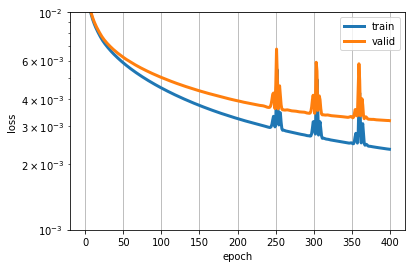

In [9]:
train_loss = np.array([i["train_loss"] for i in net1.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net1.train_history_])

plt.plot(train_loss, linewidth=3, label="train")
plt.plot(valid_loss, linewidth=3, label="valid")
plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.ylim(1e-3, 1e-2)
plt.yscale("log")
plt.show()

as it's obvious we're dealing with overfitting problem here

Let's pick a few examples from the test set and check it $\dots$

ImageId    1783
Image      1783
dtype: int64


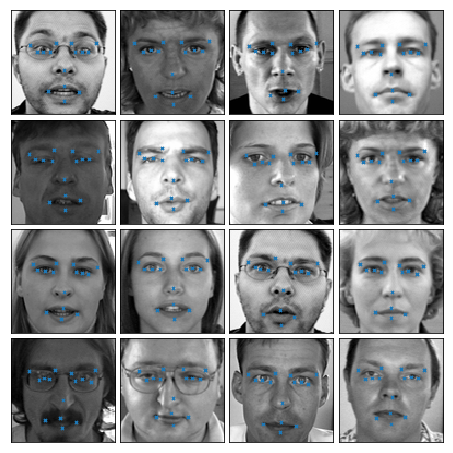

In [10]:
def plot_sample (x, y, axis):
    img = x.reshape(96, 96)
    axis.imshow(img, cmap='gray')
    axis.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

X, _   = load(test=True)
y_pred = net1.predict(X)


fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(X[i], y_pred[i], ax)
    
plt.show()



## Second model: CNN

function load2d would wraps previously written *load* and does the necessary transformations 

In [11]:
def load2d (test=False, cols=None):
    X, y = load(test=test)
    X = X.reshape(-1, 1, 96, 96)
    return X, y

In [ ]:
net2 = NeuralNet(
    
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    
    
    input_shape = (None, 1, 96, 96),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_pool_size=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_pool_size=(2, 2),
    conv3_num_filters=128, conv3_filter_size=(2, 2), pool3_pool_size=(2, 2),
    hidden4_num_units=500, hidden5_num_units=500,
    output_num_units=30, output_nonlinearity=None,
    
    
    update_learning_rate=0.01,
    update_momentum=0.9,
    
    regression=True,
    max_epochs=1000,
    verbose=1,
    
    )

X, y = load2d()
net2.fit(X, y)



import cPickle as pickle
with open('net2.pickle', 'wb') as f:
    pickle.dump(net2, f, -1)

left_eye_center_x            7039
left_eye_center_y            7039
right_eye_center_x           7036
right_eye_center_y           7036
left_eye_inner_corner_x      2271
left_eye_inner_corner_y      2271
left_eye_outer_corner_x      2267
left_eye_outer_corner_y      2267
right_eye_inner_corner_x     2268
right_eye_inner_corner_y     2268
right_eye_outer_corner_x     2268
right_eye_outer_corner_y     2268
left_eyebrow_inner_end_x     2270
left_eyebrow_inner_end_y     2270
left_eyebrow_outer_end_x     2225
left_eyebrow_outer_end_y     2225
right_eyebrow_inner_end_x    2270
right_eyebrow_inner_end_y    2270
right_eyebrow_outer_end_x    2236
right_eyebrow_outer_end_y    2236
nose_tip_x                   7049
nose_tip_y                   7049
mouth_left_corner_x          2269
mouth_left_corner_y          2269
mouth_right_corner_x         2270
mouth_right_corner_y         2270
mouth_center_top_lip_x       2275
mouth_center_top_lip_y       2275
mouth_center_bottom_lip_x    7016
mouth_center_b

     99     0.00427     0.00404    1.05716  33.25s
    100     0.00426     0.00403    1.05706  33.06s
    101     0.00426     0.00403    1.05702  33.17s
    102     0.00426     0.00403    1.05690  33.29s
    103     0.00425     0.00402    1.05684  33.06s
    104     0.00425     0.00402    1.05673  34.20s
    105     0.00424     0.00402    1.05666  33.99s
    106     0.00424     0.00401    1.05654  35.27s
    107     0.00424     0.00401    1.05648  33.07s
    108     0.00423     0.00401    1.05635  34.40s
    109     0.00423     0.00400    1.05627  33.03s
    110     0.00422     0.00400    1.05616  34.18s
    111     0.00422     0.00399    1.05609  34.17s
    112     0.00421     0.00399    1.05600  33.95s
    113     0.00421     0.00399    1.05596  34.40s
    114     0.00420     0.00398    1.05589  34.22s
    115     0.00420     0.00398    1.05580  33.12s
    116     0.00419     0.00397    1.05571  32.94s
    117     0.00419     0.00397    1.05568  33.15s
    118     0.00419     0.00397

    218     0.00364     0.00352    1.03336  34.05s
    219     0.00364     0.00352    1.03298  33.73s
    220     0.00363     0.00351    1.03255  33.19s
    221     0.00362     0.00351    1.03219  33.12s
    222     0.00362     0.00351    1.03177  33.40s
    223     0.00361     0.00350    1.03139  33.20s
    224     0.00360     0.00350    1.03100  34.09s
    225     0.00360     0.00349    1.03060  32.94s
    226     0.00359     0.00349    1.03017  33.53s
    227     0.00359     0.00348    1.02978  34.38s
    228     0.00358     0.00348    1.02944  33.04s
    229     0.00357     0.00347    1.02901  33.12s
    230     0.00357     0.00347    1.02862  33.35s
    231     0.00356     0.00346    1.02824  32.85s
    232     0.00356     0.00346    1.02780  34.10s
    233     0.00355     0.00345    1.02742  33.02s
    234     0.00354     0.00345    1.02697  33.16s
    235     0.00354     0.00344    1.02664  34.20s
    236     0.00353     0.00344    1.02622  33.73s
    237     0.00352     0.00343

    337     0.00281     0.00288    0.97473  33.07s
    338     0.00280     0.00287    0.97420  33.08s
    339     0.00279     0.00287    0.97362  34.15s
    340     0.00278     0.00286    0.97306  33.09s
    341     0.00278     0.00286    0.97251  34.66s
    342     0.00277     0.00285    0.97192  33.04s
    343     0.00276     0.00284    0.97136  33.33s
    344     0.00276     0.00284    0.97081  33.43s
    345     0.00275     0.00283    0.97025  34.58s
    346     0.00274     0.00283    0.96971  33.64s
    347     0.00274     0.00282    0.96911  33.87s
    348     0.00273     0.00282    0.96857  34.35s
    349     0.00272     0.00281    0.96802  34.31s
    350     0.00271     0.00281    0.96744  32.98s
    351     0.00271     0.00280    0.96690  34.90s
    352     0.00270     0.00279    0.96641  33.87s
    353     0.00269     0.00279    0.96587  34.10s
    354     0.00269     0.00278    0.96528  33.10s
    355     0.00268     0.00278    0.96480  33.16s
    356     0.00267     0.00277

    456     0.00212     0.00231    0.91693  33.38s
    457     0.00211     0.00230    0.91650  33.97s
    458     0.00211     0.00230    0.91610  33.65s
    459     0.00210     0.00230    0.91566  33.15s
    460     0.00210     0.00229    0.91536  34.50s
    461     0.00209     0.00229    0.91490  34.30s
    462     0.00209     0.00229    0.91458  34.29s
    463     0.00209     0.00228    0.91407  33.39s
    464     0.00208     0.00228    0.91370  33.14s
    465     0.00208     0.00228    0.91331  33.31s
    466     0.00207     0.00227    0.91290  34.50s
    467     0.00207     0.00227    0.91250  34.45s
    468     0.00207     0.00226    0.91212  33.34s
    469     0.00206     0.00226    0.91166  34.79s
    470     0.00206     0.00226    0.91126  33.61s
    471     0.00205     0.00225    0.91086  33.97s
    472     0.00205     0.00225    0.91041  34.01s
    473     0.00205     0.00225    0.91003  33.87s
    474     0.00204     0.00224    0.90970  34.82s
    475     0.00204     0.00224

    575     0.00173     0.00199    0.86940  34.06s
    576     0.00173     0.00199    0.86901  33.88s
    577     0.00173     0.00199    0.86857  35.41s
    578     0.00173     0.00199    0.86815  36.50s
    579     0.00172     0.00199    0.86766  36.13s
    580     0.00172     0.00198    0.86729  35.73s
    581     0.00172     0.00198    0.86679  33.97s
    582     0.00172     0.00198    0.86640  34.16s
    583     0.00171     0.00198    0.86591  36.27s
    584     0.00171     0.00198    0.86564  33.94s
    585     0.00171     0.00198    0.86508  33.95s
    586     0.00171     0.00197    0.86480  35.23s
    587     0.00170     0.00197    0.86426  35.35s
    588     0.00170     0.00197    0.86384  34.17s
    589     0.00170     0.00197    0.86335  34.07s
    590     0.00170     0.00197    0.86298  35.38s
    591     0.00170     0.00197    0.86251  34.91s
    592     0.00169     0.00196    0.86216  33.98s
    593     0.00169     0.00196    0.86170  34.02s
    594     0.00169     0.00196

    694     0.00150     0.00183    0.81835  34.03s
    695     0.00150     0.00183    0.81792  36.39s
    696     0.00150     0.00183    0.81734  34.19s
    697     0.00150     0.00183    0.81700  34.27s
    698     0.00149     0.00183    0.81651  34.30s
    699     0.00149     0.00183    0.81607  36.05s
    700     0.00149     0.00183    0.81570  36.21s
    701     0.00149     0.00183    0.81521  36.43s
    702     0.00149     0.00183    0.81466  37.29s
    703     0.00149     0.00182    0.81437  35.25s
    704     0.00148     0.00182    0.81383  37.85s
    705     0.00148     0.00182    0.81342  38.65s
    706     0.00148     0.00182    0.81300  34.20s
    707     0.00148     0.00182    0.81244  34.27s
    708     0.00148     0.00182    0.81202  34.29s
    709     0.00148     0.00182    0.81170  34.22s
    710     0.00147     0.00182    0.81106  35.38s


## generate output prediction

In [1]:
import pandas as pd

In [2]:
mappings = {
      'left_eye_center_x':          0,
      'left_eye_center_y':          1,
      'right_eye_center_x':         2,
      'right_eye_center_y':         3,
      'left_eye_inner_corner_x':    4,
      'left_eye_inner_corner_y':    5,
      'left_eye_outer_corner_x':    6,
      'left_eye_outer_corner_y':    7,
      'right_eye_inner_corner_x':   8,
      'right_eye_inner_corner_y':   9,
      'right_eye_outer_corner_x':   10,
      'right_eye_outer_corner_y':   11,
      'left_eyebrow_inner_end_x':   12,
      'left_eyebrow_inner_end_y':   13,
      'left_eyebrow_outer_end_x':   14,
      'left_eyebrow_outer_end_y':   15,
      'right_eyebrow_inner_end_x':  16,
      'right_eyebrow_inner_end_y':  17,
      'right_eyebrow_outer_end_x':  18,
      'right_eyebrow_outer_end_y':  19,
      'nose_tip_x':                 20,
      'nose_tip_y':                 21,
      'mouth_left_corner_x':        22,
      'mouth_left_corner_y':        23,
      'mouth_right_corner_x':       24,
      'mouth_right_corner_y':       25,
      'mouth_center_top_lip_x':     26,
      'mouth_center_top_lip_y':     27,
      'mouth_center_bottom_lip_x':  28,
      'mouth_center_bottom_lip_y':  29
    }






def submit (net, load) :

    X, _ = load(test=True)
    y_pred = net.predict(X)
    y_pred = y_pred 

    

    outputs = []
    base_df = pd.read_csv('data/IdLookupTable.csv')

    for imageId in range (1, y_pred.shape[0]+1):
        prediction = y_pred[imageId-1]
        specified_image_id_df = base_df[base_df['ImageId'] == imageId]
        for _, row in specified_image_id_df.iterrows():
            row_id = row['RowId']
            feature_name = row['FeatureName']
            mapped_index = mappings[feature_name]
            pred_value = prediction[mapped_index] * 48 + 48
            if pred_value > 96.0:
                pred_value = 96.0
            if pred_value < 0.0:
                pred_value = 0.0
            outputs.append([row_id, pred_value])


    output_df = pd.DataFrame(outputs, columns=['RowId', 'Location'])
    output_df.to_csv("output.csv", index=False)
